In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
# imports
from pathlib import Path
import sys  

# Get my_package directory path from Notebook
parent_dir = str(Path().resolve().parents[0])

# Add to sys.path
sys.path.insert(0, parent_dir)


In [8]:
from utils.experiment_utils import get_all_experiments_info, load_best_model

device = 'cuda'
configs = get_all_experiments_info('../outputs/', False)
cfgs = [
    c for c in configs if 'gmm_exp' in c['name'] 
        and c['config']['experiment']['latent_dim'] == 64
        and c['config']['experiment']['hidden_dim'] == 128
        and c['config']['dataset']['prior_mu'] == [0, 5]
        and hasattr(c['config']['encoder'], 'layers')
        and c['config']['encoder']['layers'] == 4 
]   



Base directory ../outputs/ does not exist


In [9]:
cfgs

[]

In [10]:
import hydra
# load + prep dataset
def prepare_dataset_and_mixer(cfg, set_size=None, n_sets=None, n_mixed_sets=None):
    # probs = np.column_stack((np.linspace(0, 1, num_probs), 1 - np.linspace(0, 1, num_probs)))
    if set_size is not None:
        cfg['dataset']['set_size'] = set_size
    if n_sets is not None:
        cfg['dataset']['n_sets'] = n_sets
    if n_mixed_sets is not None:
        cfg['mixer']['n_mixed_sets'] = n_mixed_sets
    dataset = hydra.utils.instantiate(cfg['dataset'])
    mixer = hydra.utils.instantiate(cfg['mixer'])
    return dataset, mixer


# load encoder and move to device
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.eval()
    enc.to(device)
    gen.to(device)
    return enc, gen

enc, gen = load_model(cfgs[0]['config'], cfgs[0]['dir'], device)


IndexError: list index out of range

In [ ]:
from torch.utils.data import DataLoader
ds, mx = prepare_dataset_and_mixer(cfgs[0]['config'], set_size=1_000_000, n_sets=100, n_mixed_sets=1)
dl = DataLoader(ds, batch_size=3, shuffle=False, collate_fn=mx.collate_fn)




In [ ]:
dl_iter = iter(dl)
gmm_s = next(dl_iter)
gmm_t = next(dl_iter)

gmm_s = next(dl_iter)
gmm_t = next(dl_iter)

gmm_s = next(dl_iter)
gmm_t = next(dl_iter)

gmm_t = next(dl_iter)
gmm_s = next(dl_iter)

gmm_s = next(dl_iter)
gmm_s = next(dl_iter)

gmm_s = next(dl_iter)
gmm_s = next(dl_iter)

gmm_s = next(dl_iter)

In [ ]:
import numpy as np
import torch
samples_s = gmm_s['samples'].squeeze()
samples_t = gmm_t['samples'].squeeze()
lat = enc(torch.from_numpy(np.concatenate([samples_s[None, :500_000, :], samples_t[None, :500_000, :]], axis=0)).float().to(device))
resample = gen.sample(lat, 1_000_000, return_trajectory=False)
# linearly interpolate between the two points
lat_interp = lat[0] + (lat[1] - lat[0]) * torch.linspace(0, 1, 20)[:, None].to(device)
resample = gen.sample(lat_interp, 1_000_000, return_trajectory=False)

Text(0.5, 1.0, 'Resampled Distribution')

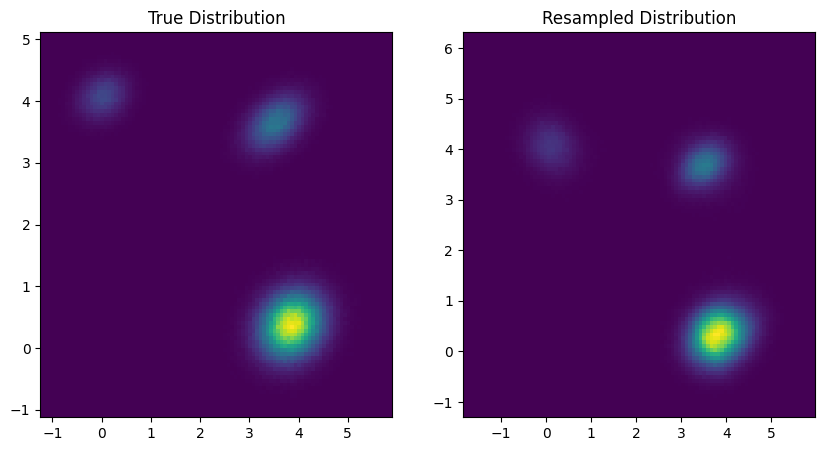

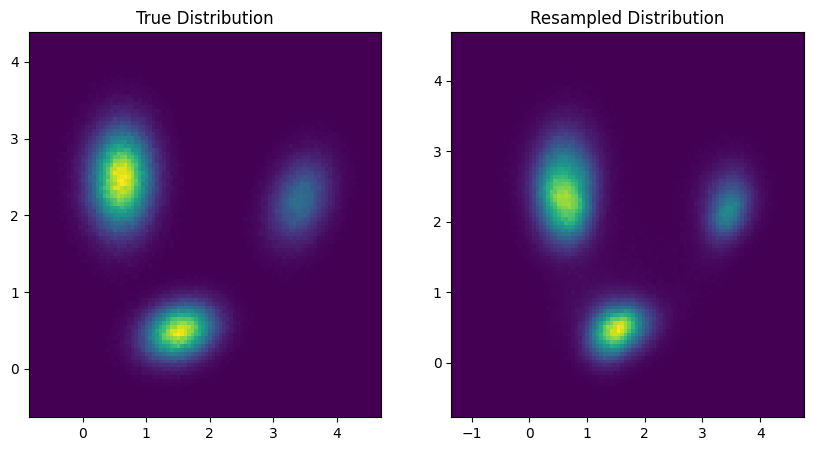

In [ ]:
from matplotlib import pyplot as plt

# create subplots

# lets use a density plot instead of a scatter plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist2d(samples_s[:, 0], samples_s[:, 1], bins=100, density=True)
axs[1].hist2d(resample[0, :, 0].cpu().numpy(), resample[0, :, 1].cpu().numpy(), bins=100, density=True)
axs[0].set_title('True Distribution')
axs[1].set_title('Resampled Distribution')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist2d(samples_t[:, 0], samples_t[:, 1], bins=100, density=True)
axs[1].hist2d(resample[-1, :, 0].cpu().numpy(), resample[-1, :, 1].cpu().numpy(), bins=100, density=True)
axs[0].set_title('True Distribution')
axs[1].set_title('Resampled Distribution')



In [ ]:
import numpy as np
from scipy.linalg import sqrtm
from ot.gmm import dist_bures_squared

def generate_ot_trajectory(mean1, cov1, mean2, cov2, n_steps=10):
    """
    Generate the correct Optimal Transport trajectory between two Gaussian distributions.
    
    Parameters:
    -----------
    mean1 : array-like
        Initial mean (2D vector)
    cov1 : array-like
        Initial covariance matrix (2x2)
    mean2 : array-like
        Final mean (2D vector)
    cov2 : array-like
        Final covariance matrix (2x2)
    n_steps : int
        Number of interpolation steps
        
    Returns:
    --------
    means : array-like
        List of interpolated means
    covs : array-like
        List of interpolated covariance matrices
    """
    mean1 = np.array(mean1)
    mean2 = np.array(mean2)
    cov1 = np.array(cov1)
    cov2 = np.array(cov2)
    
    # Generate interpolation parameters
    ts = np.linspace(0, 1, n_steps)
    
    # Initialize lists for means and covariances
    means = []
    covs = []
    
    # Compute the square root of cov1
    sqrt_cov1 = sqrtm(cov1)
    inv_sqrt_cov1 = np.linalg.inv(sqrt_cov1)
    
    # Compute A = (cov1^(1/2) * cov2 * cov1^(1/2))^(1/2)
    A = sqrtm(sqrt_cov1 @ cov2 @ sqrt_cov1)
    
    for t in ts:
        # Interpolate means linearly
        mean_t = (1 - t) * mean1 + t * mean2
        
        # Correct interpolation formula for covariances
        inner = ((1 - t) * cov1 + t * sqrtm(sqrt_cov1 @ cov2 @ sqrt_cov1))
        cov_t = inv_sqrt_cov1 @ (inner @ inner) @ inv_sqrt_cov1
        
        means.append(mean_t)
        covs.append(cov_t)
    
    return np.array(means), np.array(covs)

means1 = gmm_s['mean'].squeeze()
means2 = gmm_t['mean'].squeeze()
covs1 = gmm_s['cov'].squeeze()
covs2 = gmm_t['cov'].squeeze()
weights1 = gmm_s['weights'].squeeze()
weights2 = gmm_t['weights'].squeeze()
dists = dist_bures_squared(means1, means2, covs1, covs2)
assignments = dists.argmin(dim=0)
ot_means = []
ot_covs = []
for component in range(dists.shape[0]):
    ot_mean, ot_cov = generate_ot_trajectory(means1[component], covs1[component], means2[assignments[component]], covs2[assignments[component]], 20)
    ot_means.append(ot_mean)
    ot_covs.append(ot_cov)
    # ot_weights.append(weights1[component])

ot_means = np.array(ot_means).transpose(1, 0, 2)
ot_covs = np.array(ot_covs).transpose(1, 0, 2, 3)


ot_weights, ot_weights_cov = generate_ot_trajectory(weights1, pop_cov(weights1), weights2[assignments], pop_cov(weights2[assignments]), 20)



In [ ]:
def pop_cov(x):
    n = len(x)
    c = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            c[i, j] = x[i]*(1 - x[i]) if i == j else -x[i]*x[j]
    return c

array([[ 0.23080529, -0.18022931, -0.050576  ],
       [-0.18022931,  0.24999811, -0.06976881],
       [-0.050576  , -0.06976881,  0.12034481]])

In [ ]:
from utils.gmm_utils import fit_gmm_batch

resample_means, resample_covs, resample_weights = fit_gmm_batch(resample.cpu().numpy(), ot_means, ot_covs, ot_weights)

Fit GMM for mixture 0
Fit GMM for mixture 1
Fit GMM for mixture 2
Fit GMM for mixture 3
Fit GMM for mixture 4
Fit GMM for mixture 5
Fit GMM for mixture 6
Fit GMM for mixture 7
Fit GMM for mixture 8
Fit GMM for mixture 9
Fit GMM for mixture 10
Fit GMM for mixture 11
Fit GMM for mixture 12
Fit GMM for mixture 13
Fit GMM for mixture 14
Fit GMM for mixture 15
Fit GMM for mixture 16
Fit GMM for mixture 17
Fit GMM for mixture 18
Fit GMM for mixture 19


In [1]:
import numpy as np
# load from numerical results
ot_means, ot_covs, ot_weights = np.load('numerical_results/gmm_ot.npz')['ot_means'], np.load('numerical_results/gmm_ot.npz')['ot_covs'], np.load('numerical_results/gmm_ot.npz')['ot_weights']
resample_means, resample_covs, resample_weights = np.load('numerical_results/gmm_ot.npz')['resample_means'], np.load('numerical_results/gmm_ot.npz')['resample_covs'], np.load('numerical_results/gmm_ot.npz')['resample_weights']

In [2]:
ot_means.shape, ot_covs.shape, ot_weights.shape, resample_means.shape, resample_covs.shape, resample_weights.shape

((20, 3, 2), (20, 3, 2, 2), (20, 3), (20, 3, 2), (20, 3, 2, 2), (20, 3))

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


/orcd/data/omarabu/001/gokul/DistributionEmbeddings/utils/gmm_utils.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


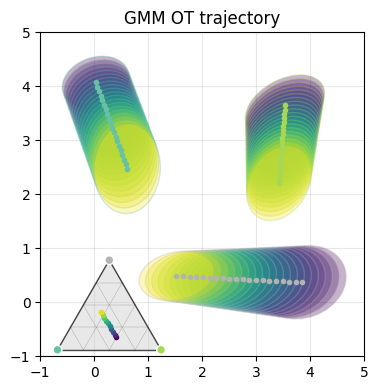

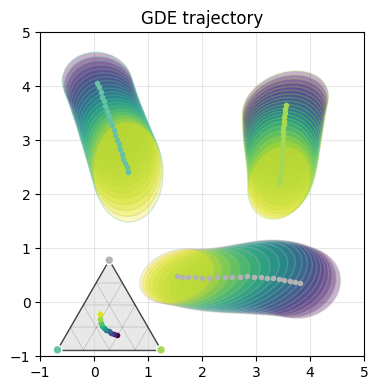

In [3]:
import matplotlib.pyplot as plt
from utils.gmm_utils import plot_gmm_trajectory
fig = plot_gmm_trajectory(ot_means, ot_covs, 
                          ot_weights, title='GMM OT trajectory', figsize=(4,4))
# plt.savefig('../figs/gmm_ot.png')

fig =  plot_gmm_trajectory(resample_means, resample_covs, resample_weights, 
                           title='GDE trajectory', figsize=(4,4))
# plt.savefig('../figs/gmm_gde.png')


In [ ]:
# save numerical results to numerical_results / 
np.savez(
    '../numerical_results/gmm_ot.npz', 
    ot_means=ot_means, ot_covs=ot_covs, ot_weights=ot_weights,
    resample_means=resample_means, resample_covs=resample_covs, resample_weights=resample_weights,
    gmm_s=gmm_s, gmm_t=gmm_t,    
)